[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

## Imports

- Install latest version of SAHI and YOLOv5:

In [ ]:
!pip install -U torch sahi yolov5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.3/956.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 70.5 MB/s eta 0:00:00


- Import required modules:

In [ ]:
# arrange an instance segmentation model for test
from sahi.utils.yolov5 import (
    download_yolov5s6_model,
)

# import required functions, classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image
from skimage import io
from skimage import exposure, transform
import random
import os
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile

%matplotlib inline

Mounted at /content/drive


## Global Variables

In [ ]:
COLAB = True

In [ ]:
ROOT_DIR_PATH = os.path.abspath('..')

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

  ROOT_DIR_PATH = os.path.abspath('drive/MyDrive/Spatial_Finance_Transport/')

IMAGE_DIR = os.path.join(ROOT_DIR_PATH, 'data/satellite_images/')
PROCESSED_IMAGE_DIR = os.path.join(ROOT_DIR_PATH, 'data/satellite_images/processed/')

ROOT_VEHICLE_COUNT_PATH = os.path.join(ROOT_DIR_PATH, 'data/predicted/vehicle_counts/')

COUNT_SITE_PATHS = ['luton_m1_2557a.csv', 'luton_m1_2557b.csv', 'havering_m25_5790a.csv', 'havering_m25_5790b.csv', 
                           'hounslow_m4_2188a.csv', 'hounslow_m4_2188b.csv',
                           'blackburn_30361033.csv', 'blackburn_30361032.csv']

## Helper Functions

In [ ]:
def extract_substring(string):
    """
    Extract a substring from a string based on characters after the last slash ("/") and before the dot (".").

    Args:
        string (str): Input string.

    Returns:
        str: Extracted substring.
    """
    # Find the index of the last slash and the dot
    slash_index = string.rfind("/")
    dot_index = string.find(".")

    # Extract the substring based on the last slash and dot indices
    if slash_index != -1 and dot_index != -1:
        substring = string[slash_index + 1:dot_index]
    else:
        substring = ""

    return substring

In [ ]:
import csv

def save_results_to_csv(results, file_path, image_id):

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Open a CSV file for writing
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['image_id', 'x_min', 'x_max', 'y_min', 'y_max', 'category_name', 'area'])

        # Write each result as a row in the CSV file

        if len(results) == 0:
          # Check if bbox is empty
            writer.writerow([image_id, 0, 0, 0, 0, 'Small Car', 0])

        else:
          for result in results:
              # Extract the relevant values from the result dictionary
              bbox = result['bbox']
              category_name = result['category_name']
              area = result['area']

              # Write the row to the CSV file
              writer.writerow([image_id, bbox[0], bbox[0] + bbox[2], bbox[1], bbox[1] + bbox[3], category_name, area])

    print(f'Saved results to CSV file: {file_path}')

In [ ]:
import os
import rasterio
import numpy as np

def convert_ms_images_to_rgb(input_dir, output_dir):
    # Get a list of all files in the input directory
    files = os.listdir(input_dir)

    # Loop through each file in the input directory
    for i, file in enumerate(files):
        # Check if the file is a .tif image
        if file.endswith(".tif"):
            # Construct the input and output file paths
            input_file_path = os.path.join(input_dir, file)
            output_file_path = os.path.join(output_dir, file)

            # Open the 8-band MS image
            with rasterio.open(input_file_path) as src:
                # Read the individual bands
                red = src.read(4)
                green = src.read(2)
                blue = src.read(1)

                # Normalize the bands to the range [0, 255]
                red = ((red - red.min()) / (red.max() - red.min()) * 255).astype('uint8')
                green = ((green - green.min()) / (green.max() - green.min()) * 255).astype('uint8')
                blue = ((blue - blue.min()) / (blue.max() - blue.min()) * 255).astype('uint8')

                # Stack the bands together to create an RGB image
                rgb = np.stack([red, green, blue], axis=0)

                # Save the RGB image using Rasterio
                profile = src.profile
                profile.update(driver='GTiff', count=3, dtype='uint8')

                with rasterio.open(output_file_path, 'w', **profile) as dst:
                    dst.write(rgb)

            print(f"Converted image saved: {output_file_path}")

In [ ]:
import os

def get_files_in_directory(directory):
    """
    Get a list of all files in a directory.

    Args:
        directory (str): Directory path.

    Returns:
        list: List of files in the directory.
    """
    files = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            files.append(file_path)
    return files

## Pre-Processing

In [ ]:
#process_images(IMAGE_DIR, PROCESSED_IMAGE_DIR)
convert_ms_images_to_rgb(IMAGE_DIR, PROCESSED_IMAGE_DIR)

Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/blackburn_30361032.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/blackburn_30361033.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/havering_m25_5790a.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/havering_m25_5790b.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/hounslow_m4_2188a.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/hounslow_m4_2188b.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/trafford_m60_9083a.tif
Converted image saved: /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/trafford_

In [ ]:
processed_image_paths = get_files_in_directory(PROCESSED_IMAGE_DIR)

## Visualise Random Processed Image

In [ ]:
files = os.listdir(PROCESSED_IMAGE_DIR)
    
# Filter the list to only include .jpg files
jpg_files = [file for file in files if file.endswith(".tif")]

# Select a random .jpg file
random_jpg_file = random.choice(jpg_files)

# Construct the file path of the random .jpg file
file_path = os.path.join(PROCESSED_IMAGE_DIR, random_jpg_file)

#Image('/content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/Luton_m1_2557_clipped.tif')

## Instantiate Model

- Instantiate a detection model by defining model weight path and other parameters:

In [ ]:
# download YOLOV5S6 model to 'models/yolov5s6.pt'
yolov5_model_path = '/content/drive/MyDrive/Spatial_Finance_Transport/models/object_detection_models/best.pt'

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=yolov5_model_path,
    confidence_threshold=0.1,
    device="cpu", # or 'cuda:0'
)

## Sliced Inference YOLOv5

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 512x512 with an overlap ratio of 0.2:

In [ ]:
for processed_image_path in processed_image_paths:

  image_id = extract_substring(processed_image_path)

  print(image_id)

  result = get_sliced_prediction(
      processed_image_path,
      detection_model,
      slice_height = 512,
      slice_width = 512,
      overlap_height_ratio = 0.25,
      overlap_width_ratio = 0.25
  )

  result_coco = result.to_coco_predictions(image_id=processed_image_path)

  print(result_coco)

  print("Number of vehicles detected: {}".format(len(result_coco)))

  save_results_to_csv(result_coco, ROOT_VEHICLE_COUNT_PATH+'vehicle_counts_'+image_id+'.csv', image_id=image_id)

trafford_m60_9083a
Performing prediction on 20 number of slices.
[{'image_id': '/content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/trafford_m60_9083a.tif', 'bbox': [292.56854248046875, 477.2584762573242, 10.635772705078125, 11.769256591796875], 'score': 0.12979058921337128, 'category_id': 5, 'category_name': 'Small Car', 'segmentation': [], 'iscrowd': 0, 'area': 125}, {'image_id': '/content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed/trafford_m60_9083a.tif', 'bbox': [437.2701110839844, 653.0213928222656, 10.18896484375, 9.60638427734375], 'score': 0.10835987329483032, 'category_id': 5, 'category_name': 'Small Car', 'segmentation': [], 'iscrowd': 0, 'area': 97}]
Number of vehicles detected: 2
Saved results to CSV file: /content/drive/MyDrive/Spatial_Finance_Transport/data/predicted/vehicle_counts/vehicle_counts_trafford_m60_9083a.csv
blackburn_30361032
Performing prediction on 18 number of slices.
[]
Number of vehicles detected: 

- Visualize predicted bounding boxes and masks over the original image:

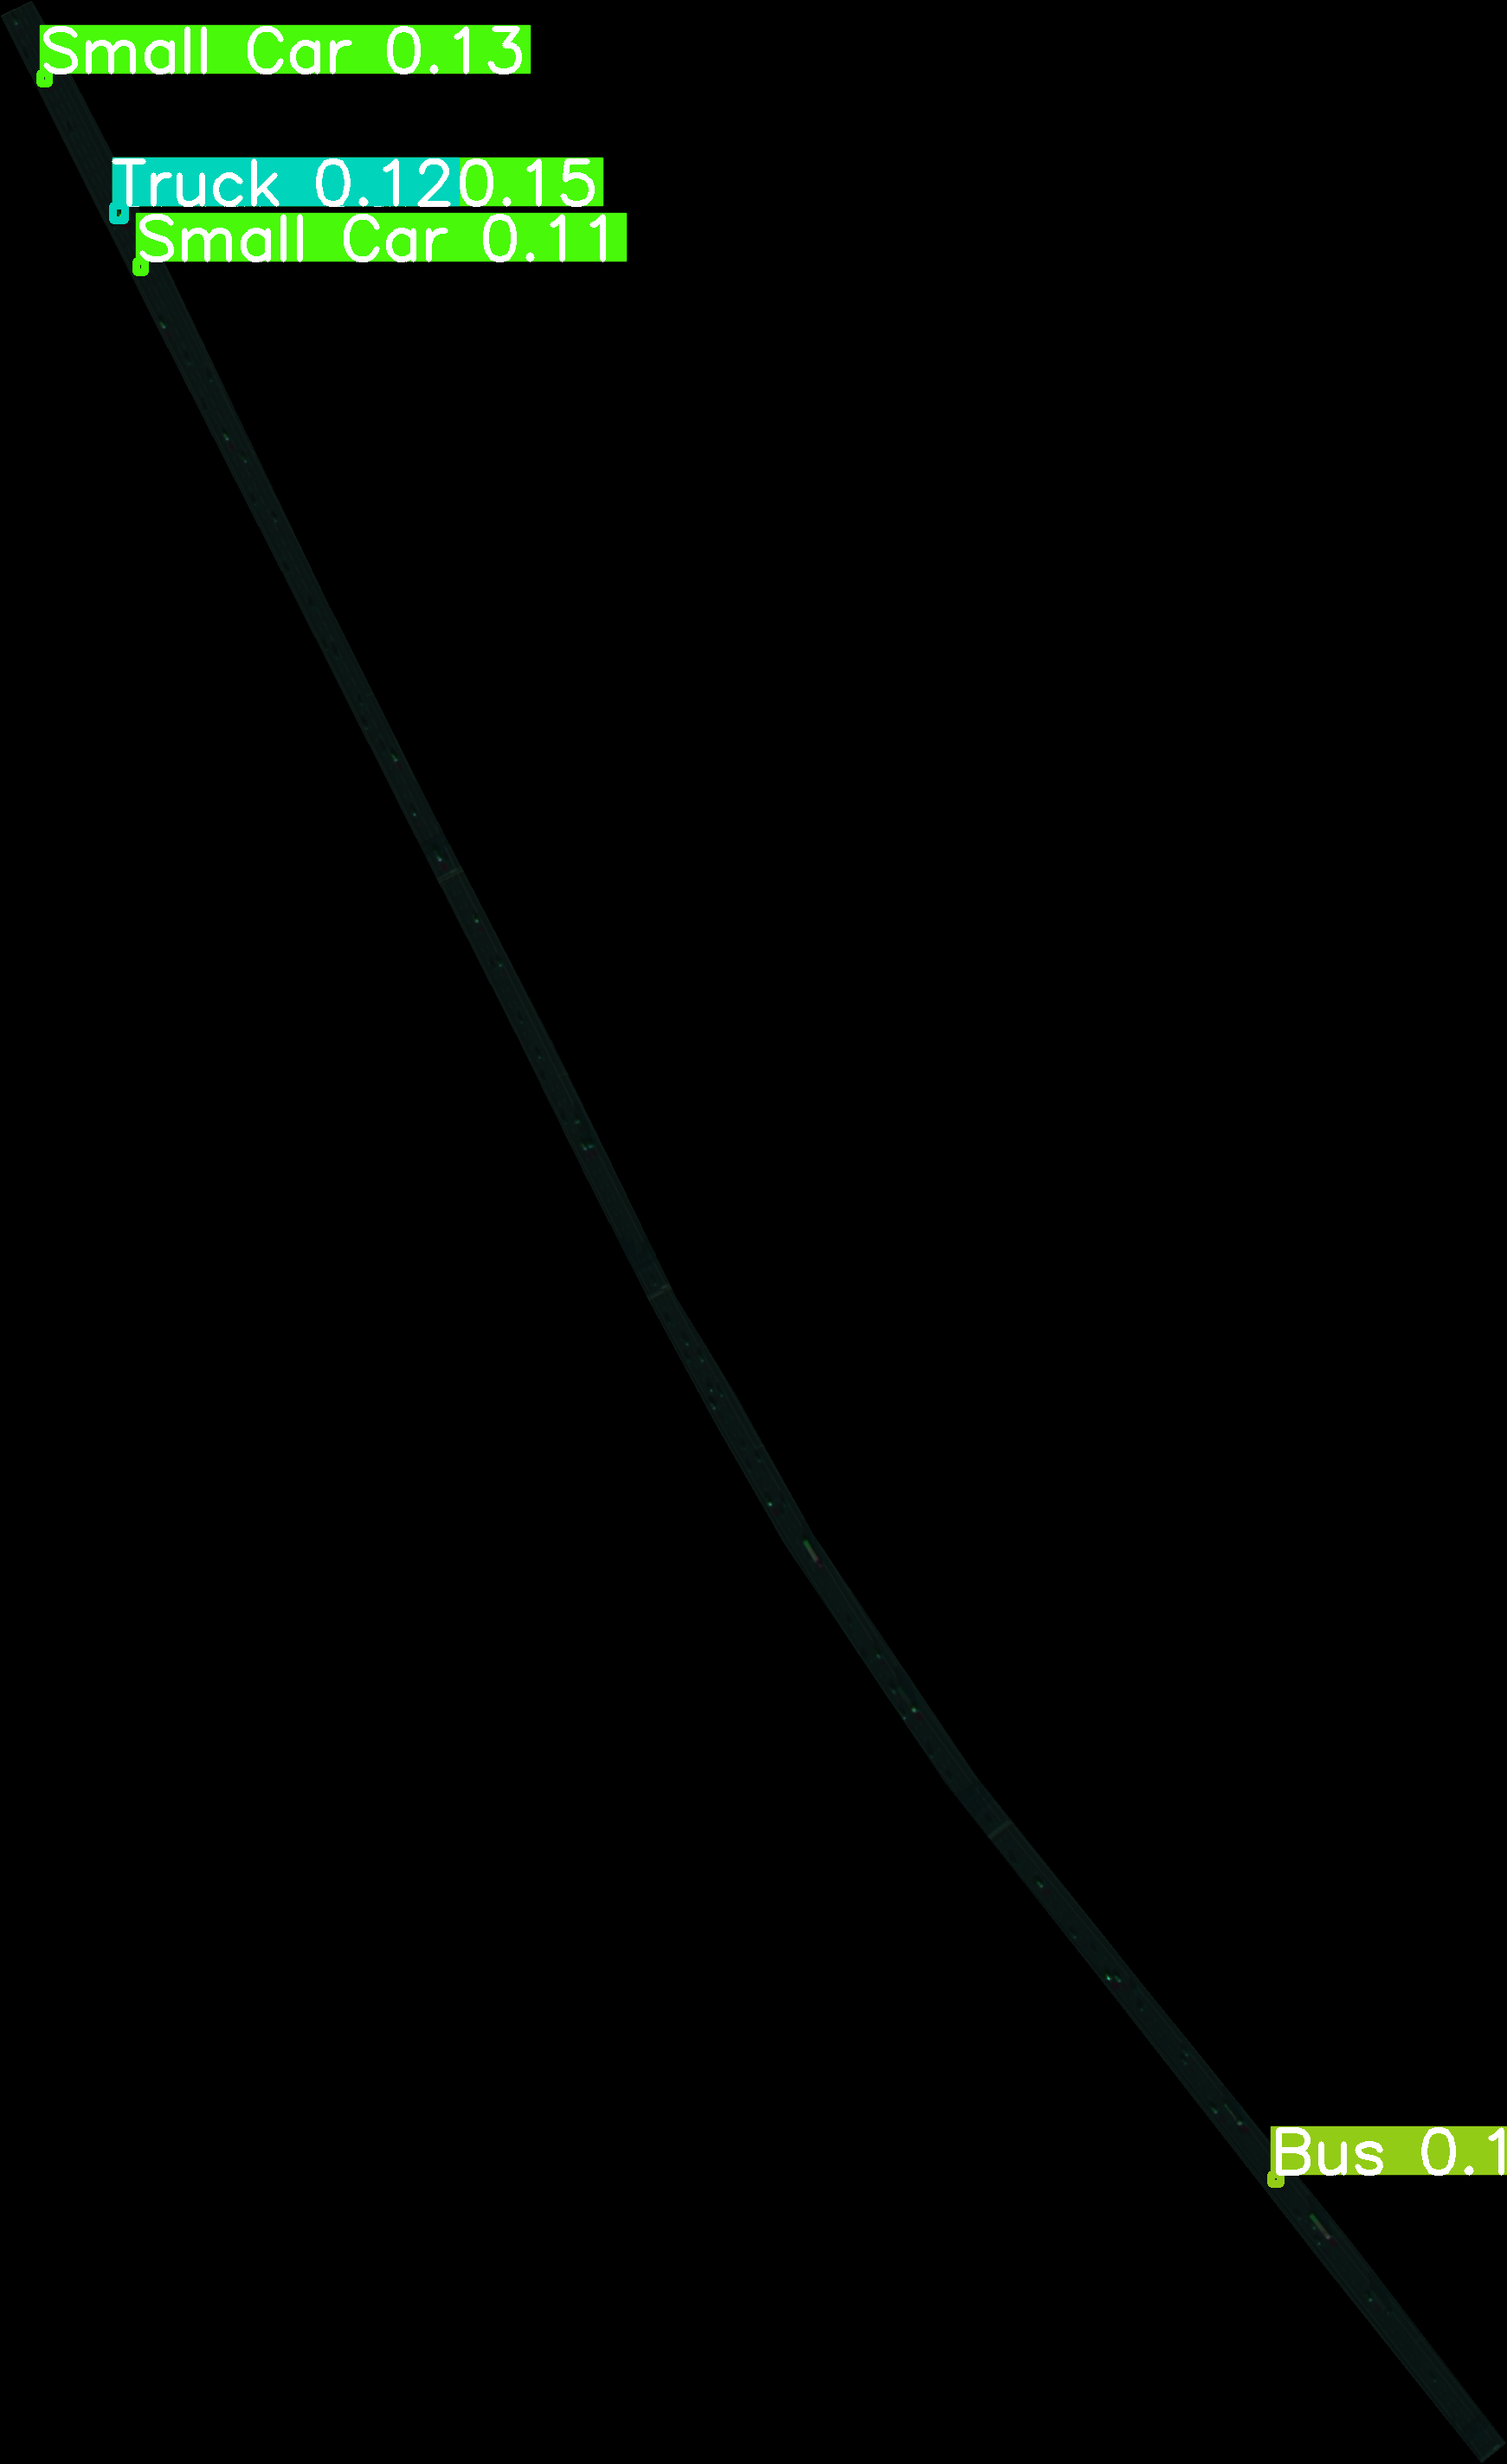

In [ ]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")